### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_mipt/homeworks/lab03_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-12-15 19:24:48--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_mipt/homeworks/lab03_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: 'sonnets.txt'

     0K .......... .......... .......... .......... .......... 42% 1017K 0s
    50K .......... .......... .......... .......... .......... 85% 3,54M 0s
   100K .......... ......                                     100% 11,7M=0,06s

2024-12-15 19:24:48 (1,77 MB/s) - 'sonnets.txt' saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = "".join([x.replace('\t\t', '').lower() for x in text])

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [32]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2024-12-15 20:39:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: 'onegin.txt.3'

     0K .......... .......... .......... .......... .......... 19%  974K 0s
    50K .......... .......... .......... .......... .......... 39% 3,50M 0s
   100K .......... .......... .......... .......... .......... 58% 1,54M 0s
   150K .......... .......... .......... .......... .......... 78% 5,43M 0s
   200K .......... .......... .......... .......... .......... 97% 1,70M 0s
   250K ......                                                100% 68,2M=0,1s

2024-12-15 20:39:32 (1,86 MB/s) - 'onegin.txt.3' saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [33]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [34]:
tokens = sorted(set(text)) + ['<sos>']
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [106]:
token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}
text_idx = [token_to_idx[char] for char in text]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [121]:
import numpy as np
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

In [122]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
def rnn_loop(char_rnn, batch_ix):

    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

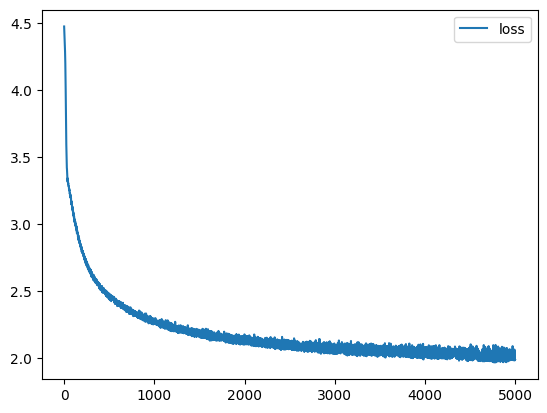

In [130]:
from IPython.display import clear_output
from random import sample
import matplotlib.pyplot as plt
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['<sos>'])

for i in range(5000):
    batch_ix = torch.tensor(next(generate_chunk()), dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape((-1, num_tokens)), actual_next_tokens.reshape(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%1000==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
# Your plot code here

In [131]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
            
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [144]:
print(generate_sample(char_rnn, ' мой дядя ', max_length=500, temperature=0.7))

<sos> мой дядя продный суг речнох стали
и расстых он там поле
пирый восли дав
славшихо,
мозный, доборых может безлучки сабыл перед видит,
уедил она?
в безумный взда, весли встведа,
она в ольгой забылит неправые уж несыбы сумитесь в он тубом,
татьяны молнизны
времах не грополесть
обин на же же содраны кольны, заседать, с госто мыслью в лесов кут их живили басала.
как и развыстей ельной может может, годавало струю мне самательча ничий водитись.
слыша могвиданье
врагох хоть надалися, молкая жавый,
обтил


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT